## 
### Método largo: Mínimos cuadrados ordinarios
#### B1
$$
\hat{\beta}_1 = \frac{n\sum_{}X_i Y_i - \sum_{}X_i\sum_{}Y_i}{n\sum_{}X^2_i - (\sum_{}X_i)^2}
$$
#### B0
$$
\hat{\beta}_0 = \frac{n \sum X_i Y_i - (\sum X_i)(\sum Y_i)}{n \sum X_i^2 - (\sum X_i)^2}
$$
### Método corto: Desviaciones 
#### B1
$$
\hat{\beta}_1 = \frac{\sum_{}X_i Y_i}{\sum_{}X^2_i}
$$
#### B0
$$
\hat{\beta}_0 = \hat{Y} - \hat{\beta}_1\hat{X}
$$

Datos cargados, con dimensiones: (1460, 6)
Datos de entrenamiento: 1168 filas
Datos de validación: 292 filas
Análisis exploratorio de los datos de entrenamiento:


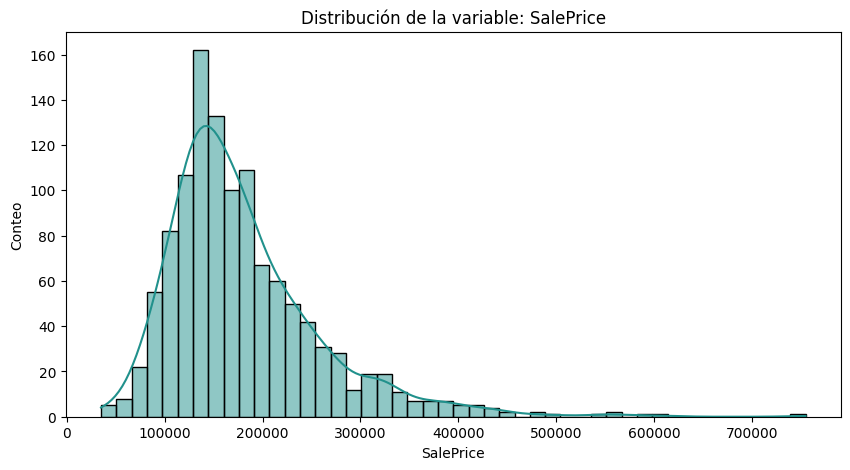

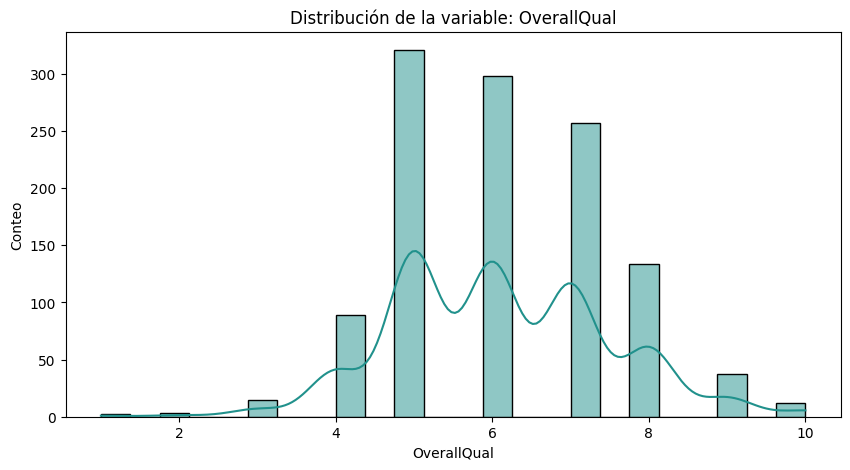

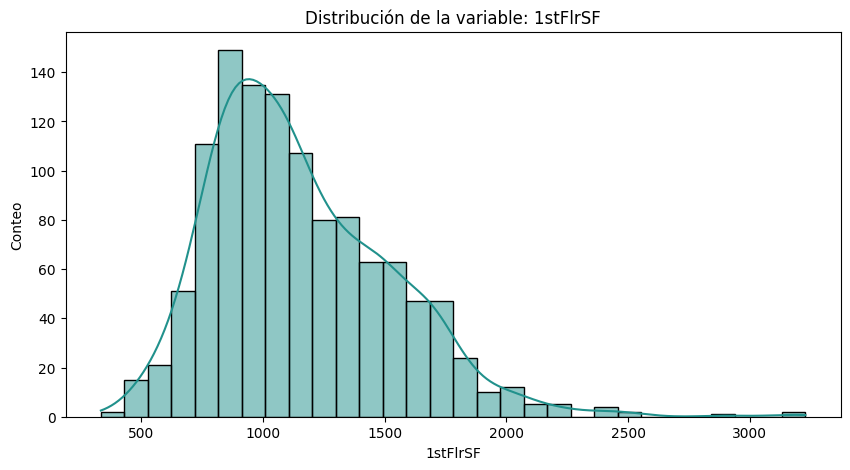

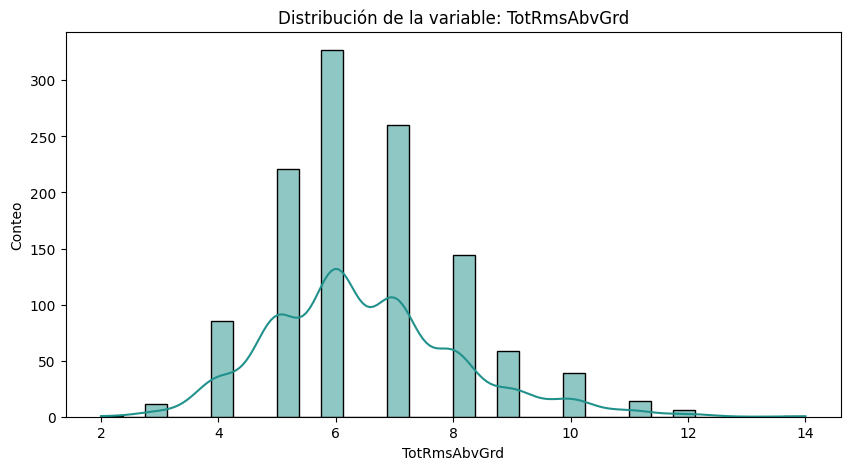

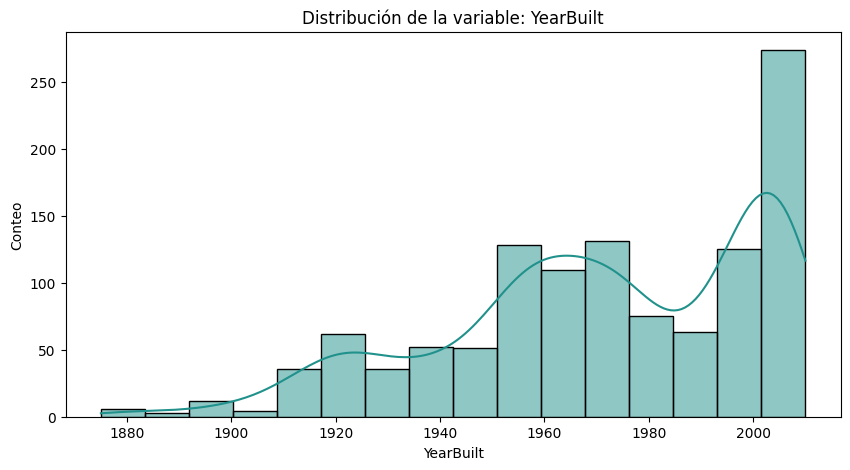

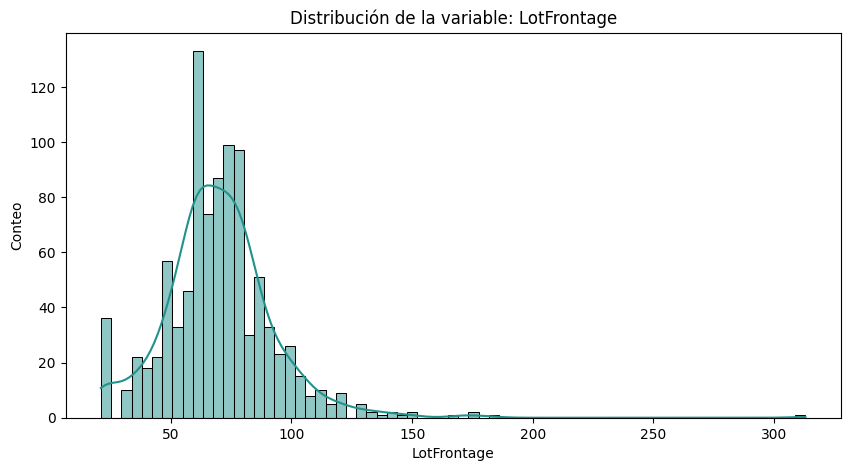

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
Media,180590.277397,6.101027,1156.323630,6.485445,1971.451199,NaN
Mediana,162950.000000,6.000000,1086.000000,6.000000,1973.000000,NaN
Máximo,755000.000000,10.000000,3228.000000,14.000000,2010.000000,NaN
Mínimo,34900.000000,1.000000,334.000000,2.000000,1875.000000,NaN
Rango,720100.000000,9.000000,2894.000000,12.000000,135.000000,NaN
Desviación Estándar,78781.951080,1.377435,373.620332,1.608452,29.938882,NaN


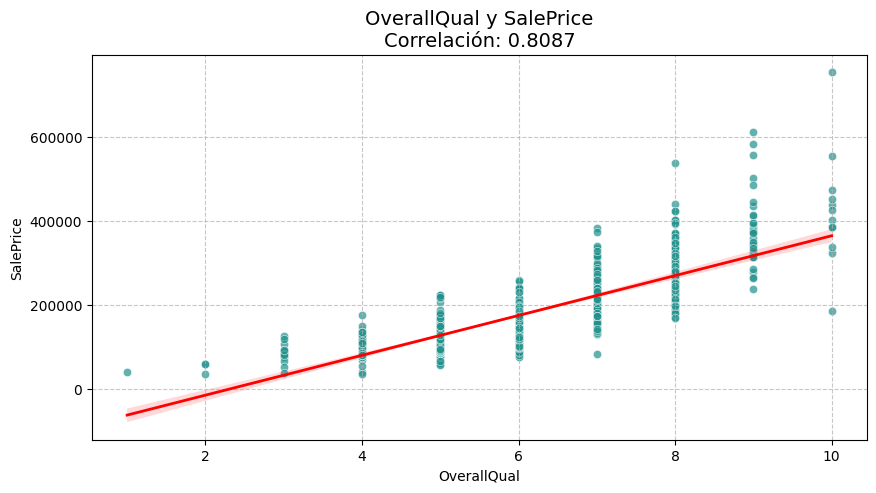

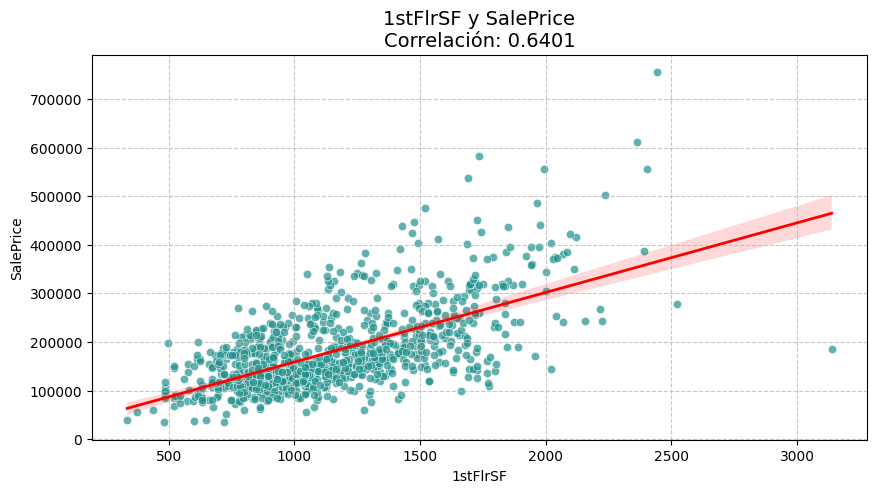

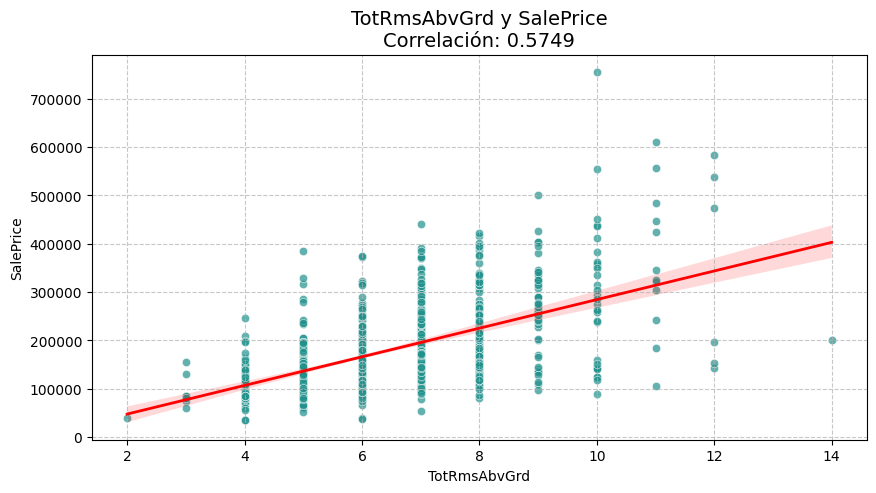

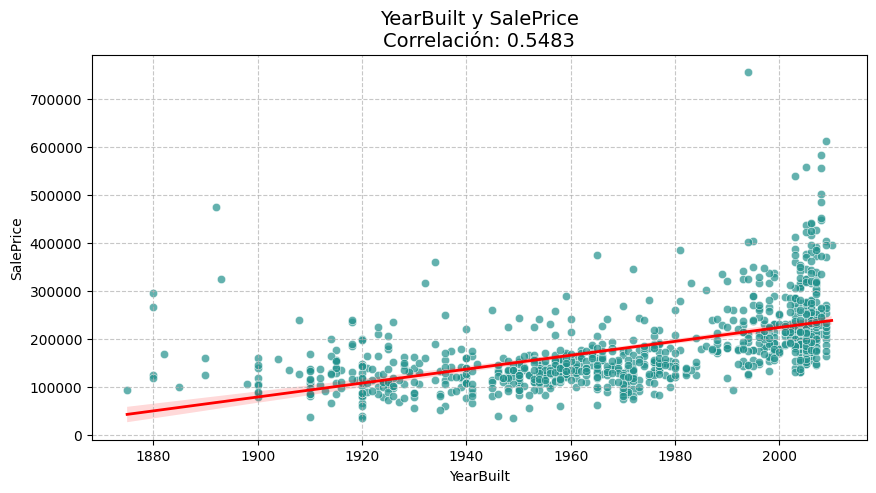

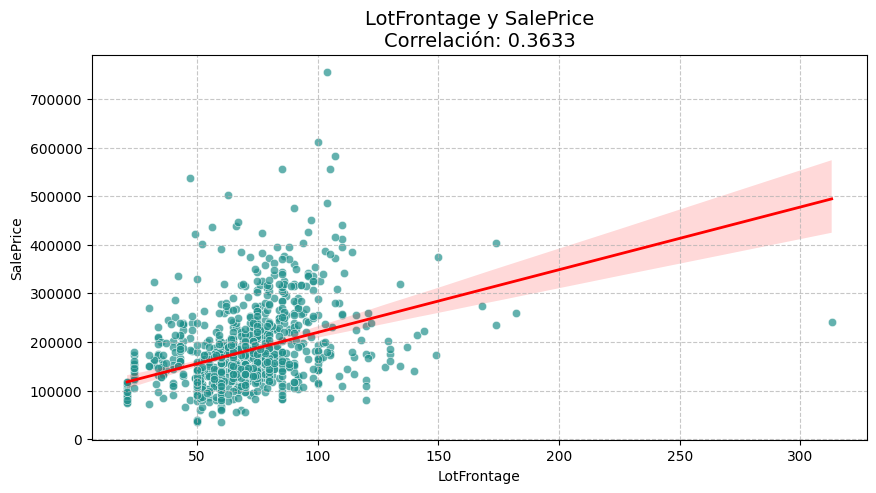

Las dos variables con mayor correlacion son: OverallQual y 1stFlrSF




In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt   
import seaborn as sns
from sklearn.linear_model import LinearRegression

class RegresionLinealManual:
    '''
    Clase para la construcción y análisis de regresión lineal univariada desde 0
    '''
    def __init__(self, archivo):
        '''
            Constructor de la clase que carga los datos y separa los datos de entrenamiento(train) y validación(tes) 
        '''
        # Carga de datos a partir del archivo o ruta de archivo .npy indicado
        _columnas = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']
        self.modelos_it = {}
        self.modelos_gd = {}
        self.modelos_sk = {}
        
        _data = np.load(archivo)
        print(f'Datos cargados, con dimensiones: {_data.shape}')
        
        # Separación de datos de entrenamiento y validación (80% - 20%)
        _total_filas = _data.shape[0]
        _indicador_split = int(_total_filas * 0.8)
        self.train = _data[:_indicador_split]
        self.test = _data[_indicador_split:]
        self.df_train = pd.DataFrame(self.train, columns=_columnas)
        self.df_test = pd.DataFrame(self.test, columns=_columnas)
        print(f'Datos de entrenamiento: {self.train.shape[0]} filas')
        print(f'Datos de validación: {self.test.shape[0]} filas')   
    
    def analisis_exploratorio(self,_plot=False):
        '''
            Función que realiza un análisis exploratorio en los datos de entrenamiento
        '''
        # Creación de DataFrame a partir de los datos de entrenamiento
        _df = self.df_train.copy()
        # Generación de estadísticas descriptivas que ofrece pandas
        print('Análisis exploratorio de los datos de entrenamiento:')
        '''
        display(_df.describe())
        display(_df.info())
        display(_df.isnull().sum())
        '''
        _estadisticas = {}
        for _c in _df.columns:
            _values = _df[_c].values
            
            # Calculando medidas de tendencia central
            _estadisticas[_c]= {
                'Media': np.mean(_values),
                'Mediana': np.median(_values),
                'Máximo': np.max(_values),
                'Mínimo': np.min(_values),
                'Rango': np.ptp(_values),
                'Desviación Estándar': np.std(_values)
            }
            if _plot:
                plt.figure(figsize=(10, 5))
                sns.histplot(_values, kde=True,color=plt.cm.viridis(0.5))
                plt.title(f'Distribución de la variable: {_c}')
                plt.xlabel(_c)
                plt.ylabel('Conteo')
                plt.show()
        display(pd.DataFrame(_estadisticas))
            
    def obtener_coef_corr(self, _plot=False):
        '''
            Función para generar los coeficientes de correlación en los datos de entrenamiento
        '''
        _df = self.df_train.copy().dropna()
        _X = _df.drop('SalePrice', axis=1)
        _y = _df.SalePrice
        _correlaciones = {}
        for _c in _X.columns:
            _x = _X[_c].values 
            _corr = np.corrcoef(_x, _y)[0, 1]
            _correlaciones[_c] = _corr
            if _plot:
                plt.figure(figsize=(10, 5))
                sns.scatterplot(x=_x, y=_y, alpha=0.7,color=plt.cm.viridis(0.5))
                sns.regplot(x=_x, y=_y, scatter=False,line_kws={'color': 'red', 'linewidth': 2})
                plt.xlabel(_c)
                plt.ylabel('SalePrice')
                plt.title(f'{_c} y SalePrice\nCorrelación: {_corr:.4f}', fontsize=14)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.show()
            
        _top2_corr = sorted(_correlaciones.items(), key=lambda x: abs(x[1]), reverse=True)[:2]
        print(f'Las dos variables con mayor correlacion son: {_top2_corr[0][0]} y {_top2_corr[1][0]}')
        return [_top2_corr[0][0], _top2_corr[1][0]]
    
    def entrenando_modelo_algebraico(self, _columna):
        '''
            Función para entrenar el modelo de regresión lineal univariada manual
        '''
        _df = self.df_train.copy()
        _X = _df[_columna].values
        _y = _df.SalePrice.values
        # Calculo de betas por meotod corto (desviaciones)
        _promedio_x = np.mean(_X)
        _promedio_y = np.mean(_y)
        _xi = _X - _promedio_x
        _yi = _y - _promedio_y        
        _suma_xi2 = np.sum(_xi**2)
        _suma_xiyi = np.sum(_xi * _yi)
        _beta1 = _suma_xiyi / _suma_xi2
        _beta0 = _promedio_y - _beta1 * _promedio_x
        print(f'Por método de desviaciones: β₀: {_beta0:.4f}, β₁: {_beta1:.4f}')
        
        # Calculo de betas por método de mínimos cuadrados
        _n = len(_X)
        _suma_Xy = np.sum(_X * _y)
        _suma_X = np.sum(_X)
        _suma_y = np.sum(_y)
        _suma_X2 = np.sum(_X**2)
        _beta1 = (_n * _suma_Xy - (_suma_X * _suma_y)) / (_n * _suma_X2 - (_suma_X)**2)
        _beta0 = ((_suma_X2 * _suma_y) - (_suma_X * _suma_Xy)) / (_n * _suma_X2 - (_suma_X)**2)
        print(f'Por método de mínimos cuadrados: β₀: {_beta0:.4f}, β₁: {_beta1:.4f}')    
        return _beta0, _beta1

    def entrenando_modelo_gradiente(self,_columna,_epochs=1000,_lr=0.01,_imprimir_error_cada=100,_plot=False):
        '''
        Función para entrenar un modelo de regresión lineal desde 0 
        '''
        np.random.seed(12345)
        
        _df = self.df_train.copy()
        _n = _df.shape[0]
        
        _X = _df[_columna].values
        _y = _df.SalePrice.values
        _X_mean = np.mean(_X)
        _X_std = np.std(_X)
        _X_norm = (_X - _X_mean) / _X_std
        
        # Inicializar parámetros del modelo (β₁, β₀)
        _parametros = np.zeros(2)
        _historial_modelos = {}
        _errores = np.zeros(_epochs)
        _x = np.column_stack((_X_norm, np.ones(_X_norm.shape)))
        
        for _i in range(_epochs): 
            _y_pred = np.dot(_x, _parametros)
            # Calcular el error
            epsilon = 1e-10
            #error = np.mean(np.abs((y - y_pred) / (np.abs(y) + epsilon))) * 100
            _error = np.sum((_y - _y_pred)**2) * (1/(2 * _n))
            _errores[_i] = _error
            _historial_modelos[_i] = _parametros.copy()
            if (_i+1) % _imprimir_error_cada == 0 or _i == 0 or _i == _epochs - 1:
                print(f'Epoch: {_i+1}/{_epochs}, Error: {_error:.4f}')
            
            _gradientes = np.zeros(2)
            _gradientes[0] = (1 / _n) * np.sum((_y_pred - _y) * _X_norm) 
            _gradientes[1] = (1 / _n) * np.sum(_y_pred - _y)
            _parametros -= _lr * _gradientes
        #display(historial_modelos)    
        _beta1 = _parametros[0] / _X_std
        _beta0 = _parametros[1] - (_parametros[0] * _X_mean / _X_std)
        #print(f'Coeficientes del modelo: β₁={_beta1:.4f}, β₀={_beta0:.4f}')
        # Guardar modelo final
        modelo_final = {
            'beta1': _beta1
            ,'beta0': _beta0
            ,'x_mean': _X_mean
            ,'x_std': _X_std
        }
        if _plot:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(_errores)), _errores)
            plt.title(f'Curva de Aprendizaje para {_columna}')
            plt.xlabel('Iteraciones')
            plt.ylabel('Error Cuadrático Medio')
            plt.grid(True)
            # Marcar error mínimo
            min_error = np.min(_errores)
            min_iter = np.argmin(_errores)
            plt.axhline(y=min_error, color='r', linestyle='--',label=f'Error mínimo: {min_error:.6f} (iter {min_iter})')
            plt.legend()
            plt.show()
        print(f'Por método del gradiente: β₀: {_beta0:.4f}, β₁: {_beta1:.4f}')
        self.modelos_gd[f'columna_{_columna}'] = modelo_final
        return _historial_modelos,_errores
    
    def entrenando_model_sklearn(self,_columna):
        '''
        Función para entrenar un modelo de regresión lineal con sk learn 
        '''
        if _columna not in self.df_train.columns:
            print(f'La _columna {_columna} no se encuentra en el conjunto de datos')
            return

        _df = self.df_train.copy()
        _X = _df[_columna].values
        _y = _df.SalePrice.values
        _X = _X.reshape(-1, 1)
        _modelo = LinearRegression()
        _modelo.fit(_X, _y)
        _beta1 = _modelo.coef_[0]
        _beta0 = _modelo.intercept_
        print(f'Por uso de librería: β₀={_beta0:.4f}, β₁={_beta1:.4f}')
        return _modelo
    
    def _plot_evolucion_modelo(self, _hist, _columna, _n=5):
        '''
        Visualiza la evolución del modelo en diferentes iteraciones.
        '''

        # Obtener datos
        _df = self.df_train.copy()
        _X = _df[_columna].values
        _y = _df.SalePrice.values
        
        # Estadísticas para normalización
        _X_mean = np.mean(_X)
        _X_std = np.std(_X)
        
        # Crear figura
        plt.figure(figsize=(10, 6))
        plt.scatter(_X, _y, alpha=0.5, label='Datos de entrenamiento')
        
        # Seleccionar iteraciones a mostrar
        _total_iter = len(_hist)
        _step = max(1, _total_iter // _n)
        _iteraciones = list(range(0, _total_iter, _step))
        
        # Asegurar que se incluya la última iteración
        if _total_iter - 1 not in _iteraciones:
            _iteraciones.append(_total_iter-1)
        
        # Colores para diferentes _iteraciones
        _colores = plt.cm.viridis(np.linspace(0, 1, len(_iteraciones)))
        
        # Graficar cada modelo
        for _idx, _iter_num in enumerate(_iteraciones):
            _params = _hist[_iter_num]
            
            # Crear línea de regresión
            _x_plot = np.linspace(min(_X), max(_X), 100)
            _x_plot_norm = (_x_plot - _X_mean) / _X_std
            _y_plot = _params[0] * _x_plot_norm + _params[1]
            
            plt.plot(_x_plot, _y_plot, color=_colores[_idx], 
                    label=f'Iteración {_iter_num+1}')
        
        plt.title(f'Evolución del Modelo para columna: {_columna}')
        plt.xlabel(f'Columna: {_columna}')
        plt.ylabel('Variable Dependiente')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

obj = RegresionLinealManual('proyecto_training_data.npy')
obj.analisis_exploratorio(_plot=True)
for _col in obj.obtener_coef_corr(_plot=True):
    print('')
    print(f'############################### Entrenando modelo para la columna {_col} ###############################')
    obj.entrenando_modelo_algebraico(_col)
    _hist,_error = obj.entrenando_modelo_gradiente(_col,_epochs=1000,_lr=0.01,_imprimir_error_cada=100,_plot=True)
    obj._plot_evolucion_modelo(_hist, _col,_n=10)
    _ = obj.entrenando_model_sklearn(_col)

Las dos variables con mayor correlacion son: OverallQual y 1stFlrSF

############################### Entrenando modelo para la columna OverallQual ###############################
Por método de desviaciones: β₀: -96469.5713, β₁: 45411.9988
Por método de mínimos cuadrados: β₀: -96469.5713, β₁: 45411.9988
Epoch: 1/1000, Error: 19409722053.2217
Epoch: 100/1000, Error: 3643441867.4552
Epoch: 200/1000, Error: 1481399914.0515
Epoch: 300/1000, Error: 1191730236.1053
Epoch: 400/1000, Error: 1152920386.8378
Epoch: 500/1000, Error: 1147720655.8517
Epoch: 600/1000, Error: 1147023997.5848
Epoch: 700/1000, Error: 1146930659.5367
Epoch: 800/1000, Error: 1146918154.1354
Epoch: 900/1000, Error: 1146916478.6658
Epoch: 1000/1000, Error: 1146916254.1869


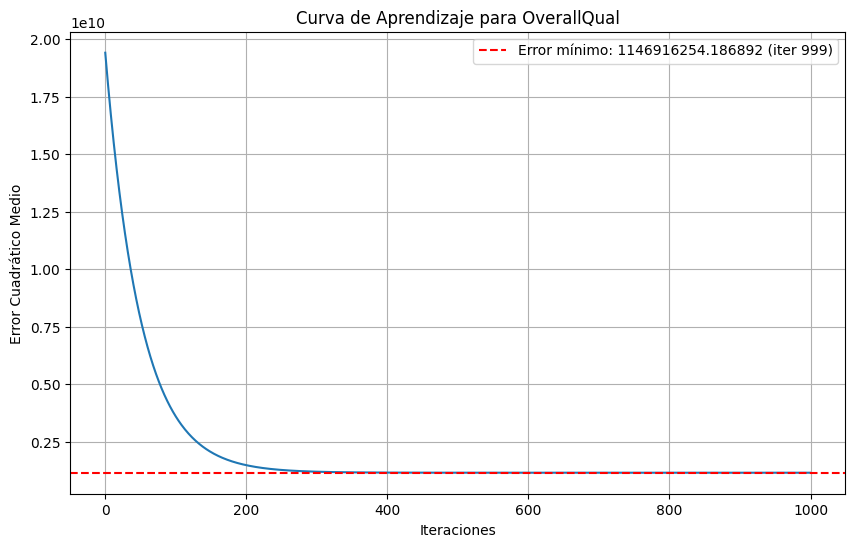

Por método del gradiente: β₀: -96465.4066, β₁: 45410.0383


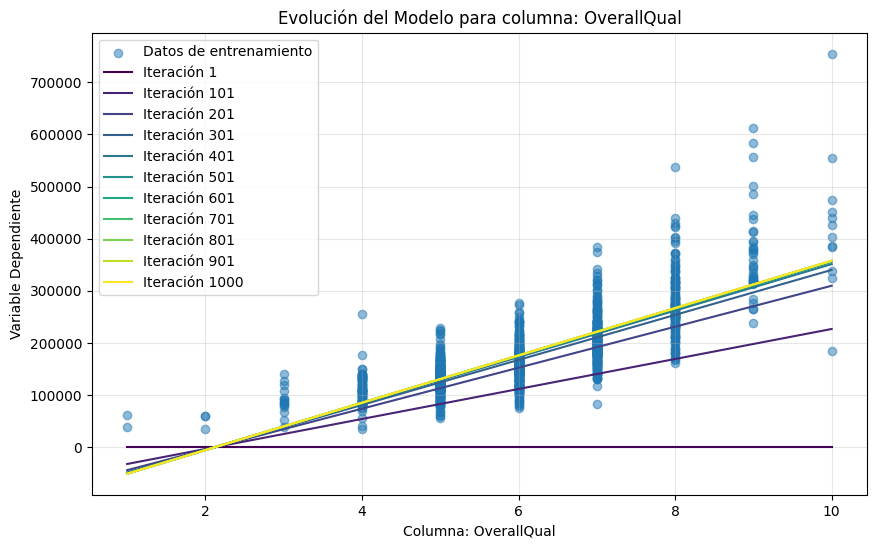

Por uso de librería: β₀=-96469.5713, β₁=45411.9988

############################### Entrenando modelo para la columna 1stFlrSF ###############################
Por método de desviaciones: β₀: 30324.5852, β₁: 129.9512
Por método de mínimos cuadrados: β₀: 30324.5852, β₁: 129.9512
Epoch: 1/1000, Error: 19409722053.2217
Epoch: 100/1000, Error: 4314841187.8721
Epoch: 200/1000, Error: 2244868732.2272
Epoch: 300/1000, Error: 1967534495.6550
Epoch: 400/1000, Error: 1930377344.8121
Epoch: 500/1000, Error: 1925399041.8235
Epoch: 600/1000, Error: 1924732050.4077
Epoch: 700/1000, Error: 1924642687.1147
Epoch: 800/1000, Error: 1924630714.2498
Epoch: 900/1000, Error: 1924629110.1292
Epoch: 1000/1000, Error: 1924628895.2097


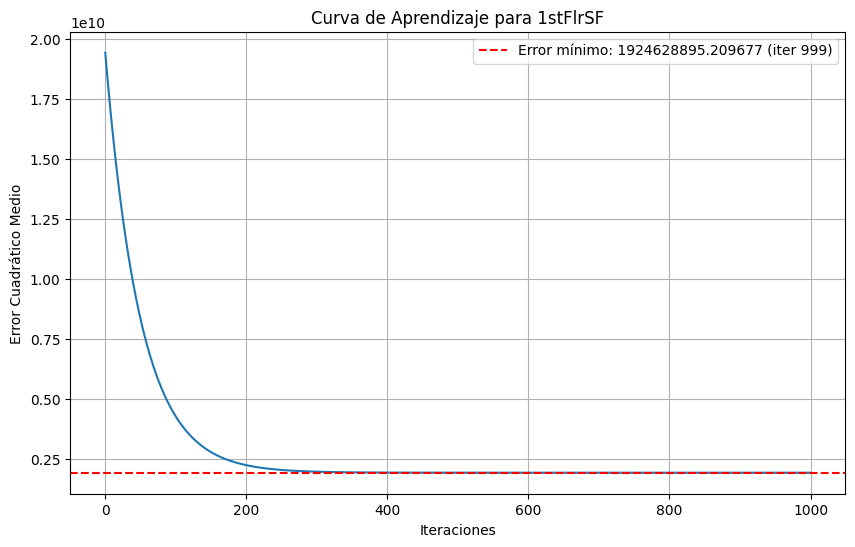

Por método del gradiente: β₀: 30323.2760, β₁: 129.9456


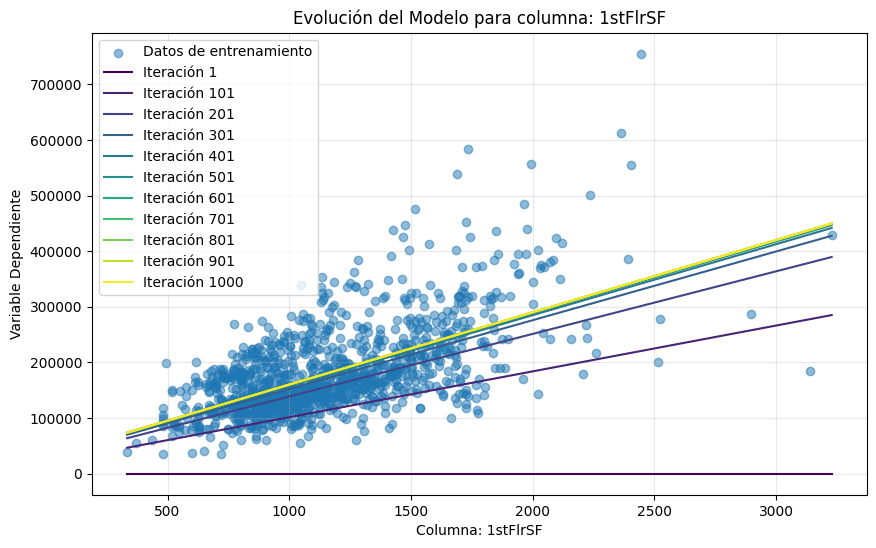

Por uso de librería: β₀=30324.5852, β₁=129.9512


In [57]:
for _col in obj.obtener_coef_corr():
    print('')
    print(f'############################### Entrenando modelo para la columna {_col} ###############################')
    obj.entrenando_modelo_algebraico(_col)
    _hist,_error = obj.entrenando_modelo_gradiente(_col,_epochs=1000,_lr=0.01,_imprimir_error_cada=100,_plot=True)
    obj._plot_evolucion_modelo(_hist, _col,_n=10)
    _ = obj.entrenando_model_sklearn(_col)